In [1]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

In [10]:
new_img = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-2d\nnUNet_raw_data\Task504_CardiacOCT\imagesTr\NLDISALA0070_1_frame0_035_0000.nii.gz')
new_img_data = sitk.GetArrayFromImage(new_img)

In [11]:
seg_to_fix = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-2d\nnUNet_raw_data\Task504_CardiacOCT\labelsTr\NLDISALA0070_1_frame0_035.nii.gz')
seg_to_fix_data = sitk.GetArrayFromImage(seg_to_fix)

In [27]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center >= radius
    mask = np.expand_dims(mask, 0)

    return mask
    
def resize_image(raw_frame, downsample=True):
        
    frame_image = sitk.GetImageFromArray(raw_frame)

    if downsample == True:
        new_shape = (704, 704)

    else:
        new_shape = (1024, 1024)


    new_spacing = (frame_image.GetSpacing()[0]*sitk.GetArrayFromImage(frame_image).shape[1]/1024,
                        frame_image.GetSpacing()[1]*sitk.GetArrayFromImage(frame_image).shape[1]/1024)

    resampler = sitk.ResampleImageFilter()

    resampler.SetSize(new_shape)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetOutputSpacing(new_spacing)

    resampled_seg = resampler.Execute(frame_image)
    resampled_seg_frame = sitk.GetArrayFromImage(resampled_seg)

    return resampled_seg_frame

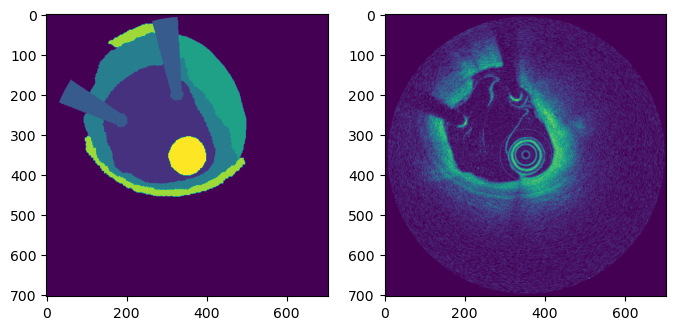

In [14]:
fig, axes = plt.subplots(1,2, figsize=(8,8))

axes[0].imshow(seg_to_fix_data[0])
axes[1].imshow(new_img_data[0])

In [31]:
#resampled_seg = resize_image(raw_frame)

resampled_seg_data = resize_image(raw_frame, False)
resampled_seg_data = resampled_seg_data[160:864, 160:864]

circular_mask = create_circular_mask(resampled_seg_data.shape[0], resampled_seg_data.shape[1], radius=346)
masked_resampled_frame = np.invert(circular_mask) * resampled_seg_data


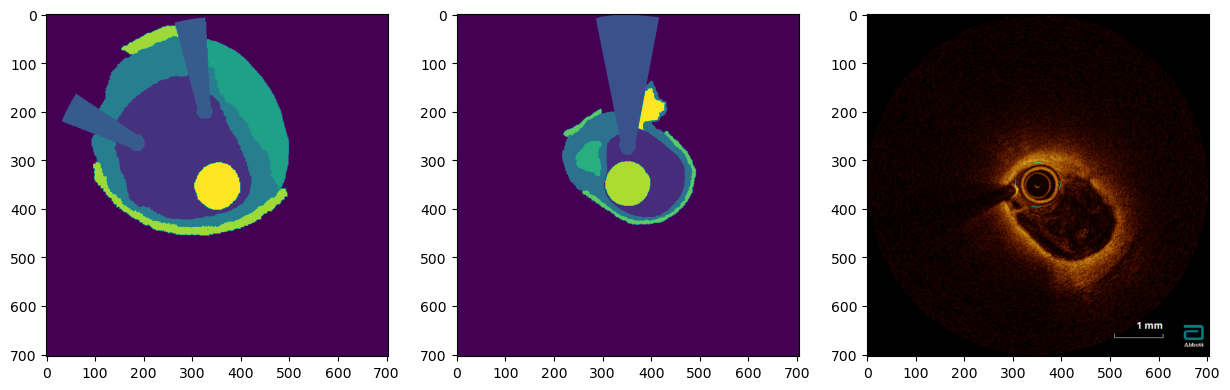

In [32]:
fig, axes = plt.subplots(1,3, figsize=(15,15))

axes[0].imshow(masked_resampled_frame[0])
axes[1].imshow(raw_frame_good)
axes[2].imshow(new_img_data[0,:,:,:])